# IMPORTS

In [105]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings

# configuration
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)

# LOAD DATA

In [35]:
# load data
df = pd.read_csv("EasyVisa.csv")

In [36]:
# preview data
df.sample(10)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
7905,EZYV7906,Asia,Bachelor's,N,Y,963,1971,South,29872.70,Year,Y,Certified
24581,EZYV24582,Asia,Master's,Y,N,4503,2000,Midwest,154937.84,Year,Y,Certified
22034,EZYV22035,Asia,High School,Y,N,2769,2012,West,37185.38,Week,Y,Certified
11827,EZYV11828,Asia,High School,Y,N,3502,1931,South,66600.44,Year,Y,Denied
4235,EZYV4236,North America,Master's,N,N,775,2012,West,106851.83,Year,Y,Denied
25217,EZYV25218,Asia,Bachelor's,N,Y,2393,1995,West,191745.22,Year,Y,Denied
23478,EZYV23479,Asia,Doctorate,Y,N,1044,2001,Northeast,65874.08,Year,Y,Denied
17141,EZYV17142,Asia,Master's,Y,N,392,2011,Midwest,118752.61,Year,Y,Certified
4629,EZYV4630,Asia,Master's,Y,N,1544,1997,Northeast,28935.69,Year,N,Certified
22019,EZYV22020,Europe,Master's,Y,N,1841,1953,Midwest,80815.70,Year,Y,Certified


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


# DATA PRE-PROCESSING

## 1. Missing Values

In [38]:
# check null values
df.isnull().mean().mul(100).round(2).sort_values(ascending=False)

case_id                  0.0
continent                0.0
education_of_employee    0.0
has_job_experience       0.0
requires_job_training    0.0
no_of_employees          0.0
yr_of_estab              0.0
region_of_employment     0.0
prevailing_wage          0.0
unit_of_wage             0.0
full_time_position       0.0
case_status              0.0
dtype: float64

- no null values in the dataset

## 2. Duplicate Values

In [39]:
df.duplicated().sum()

0

- No duplicates in the dataset

## 3. Drop Columns

In [40]:
# drop columns
print(df.shape)
df.drop(['case_id'], axis=1, inplace=True)
print(df.shape)

(25480, 12)
(25480, 11)


# FEATURE ENGINEERING

## 1. Feature Extraction

In [41]:
# create today's date
todays_date = date.today()
current_year = todays_date.year
print(todays_date, current_year)

2024-09-07 2024


### `company_age`

In [42]:
df['company_age'] = current_year - df['yr_of_estab']

In [43]:
df.sample(3)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
7465,Asia,Master's,N,N,266,1998,Northeast,64640.11,Year,Y,Certified,26
20051,North America,Master's,N,N,758,2003,Midwest,78900.51,Year,N,Certified,21
9908,Asia,Master's,Y,N,636,2005,South,124218.44,Year,Y,Certified,19


In [44]:
df.drop(['yr_of_estab'], axis=1, inplace=True)

## 2. Type of Features

### Numerical and Categorical Features

In [45]:
cat_features = df.drop('case_status', axis=1).select_dtypes(include='O').columns.to_list()
num_features = df.drop('case_status', axis=1).select_dtypes(exclude='O').columns.to_list()
print(f"There are {len(num_features)} Numerical Features: {num_features}")
print(f"There are {len(cat_features)} Numerical Features: {cat_features}")

There are 3 Numerical Features: ['no_of_employees', 'prevailing_wage', 'company_age']
There are 7 Numerical Features: ['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']


### Discrete and Continous Features

In [46]:
discrete_num_features = [feature for feature in num_features if df[feature].nunique()<=25]
continous_num_features = [feature for feature in num_features if feature not in discrete_num_features]
print(f"There are {len(discrete_num_features)} Numerical Features: {discrete_num_features}")
print(f"There are {len(continous_num_features)} Numerical Features: {continous_num_features}")

There are 0 Numerical Features: []
There are 3 Numerical Features: ['no_of_employees', 'prevailing_wage', 'company_age']


## 3. Split X & y

In [47]:
X = df.drop(['case_status'], axis=1)
y = df['case_status']

In [48]:
y = np.where(y=='Denied', 1, 0)

In [49]:
y

array([1, 0, 1, ..., 0, 0, 0])

## 4. Feature Transformation

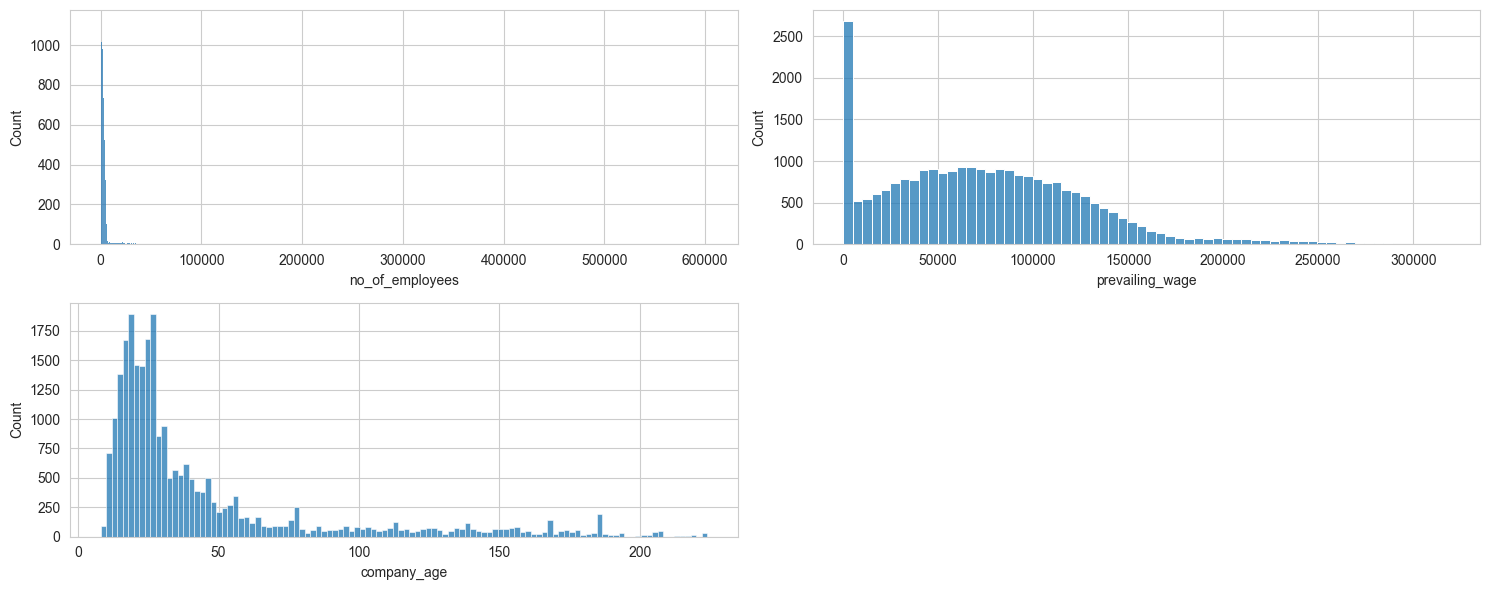

In [50]:
plt.figure(figsize=(15,6))
for i, col in enumerate(num_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=X[col])
    # sns.histplot(x=X[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

In [51]:
# check skewness
X[continous_num_features].skew(axis=0, skipna=True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

Observations
- `no_of_employees` and `company_age` columns are heavily skewed
- Requires outlier handling and then skewness treatment

### Power Transformation

In [52]:
pt = PowerTransformer(method='yeo-johnson')
transform_features = ['no_of_employees', 'company_age']
X_copy = pt.fit_transform(X[transform_features])
X_copy = pd.DataFrame(X_copy, columns=transform_features)
X_copy

,no_of_employees,company_age
0,1.517300,-0.952162
1,0.030912,-0.462942
2,2.885076,-1.075820
3,-1.343550,1.629178
4,-0.432287,-0.733953
...,...,...
25475,0.079917,-1.075820
25476,0.235747,-0.838640
25477,-0.413885,1.547445
25478,-0.111949,1.683834


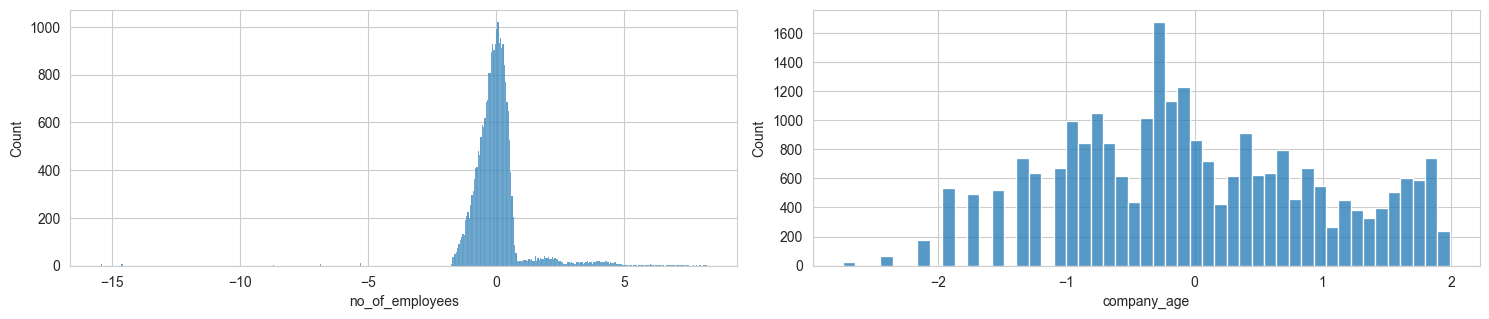

In [53]:
plt.figure(figsize=(15,6))
for i, col in enumerate(transform_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=X_copy[col])
    # sns.histplot(x=X[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

In [54]:
# check skewness
X_copy.skew(axis=0, skipna=True)

no_of_employees    0.399339
company_age        0.103264
dtype: float64

## 5. Feature Encoding and Scaling

One Hot Encoding for Columns which had lesser unique values and not ordinal
- One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

Ordinal Encoding for Columns which has many unique categories
- Ordinal encoding is used here as label encoder is supported for column transformer.
- Ordinal encoding is used for Ordinal Variable. Variable comprises a finite set of discrete values with a ranked ordering between values.

Standard Scaler
- Standardize features by removing the mean and scaling to unit variance.

Power Transformer
- Power transforms are a technique for transforming numerical input or output variables to have a Gaussian or more-Gaussian-like probability distribution.

In [55]:
# categorical features
for feature in cat_features:
    print(feature, ':', df[feature].nunique())

continent : 6
education_of_employee : 4
has_job_experience : 2
requires_job_training : 2
region_of_employment : 5
unit_of_wage : 4
full_time_position : 2


In [56]:
df[cat_features].sample(5)

,continent,education_of_employee,has_job_experience,requires_job_training,region_of_employment,unit_of_wage,full_time_position
9273,North America,Master's,N,N,Northeast,Year,N
11199,Asia,Master's,N,N,South,Year,Y
261,Asia,Master's,N,Y,Northeast,Year,Y
471,Asia,Master's,N,N,West,Year,N
19098,Europe,Bachelor's,Y,N,West,Year,Y


In [57]:
or_columns = ['has_job_experience', 'requires_job_training', 'full_time_position', 'education_of_employee']     # Ordinal
oh_columns = ['continent', 'unit_of_wage', 'region_of_employment']  # One Hot Encoder
transform_columns = ['no_of_employees', 'company_age']

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
or_transformer = OrdinalEncoder()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder', oh_transformer, oh_columns),
        ('OrdinalEncoder', or_transformer, or_columns),
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [58]:
X

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,company_age
0,Asia,High School,N,N,14513,West,592.2029,Hour,Y,17
1,Asia,Master's,Y,N,2412,Northeast,83425.6500,Year,Y,22
2,Asia,Bachelor's,N,Y,44444,West,122996.8600,Year,Y,16
3,Asia,Bachelor's,N,N,98,West,83434.0300,Year,Y,127
4,Africa,Master's,Y,N,1082,South,149907.3900,Year,Y,19
...,...,...,...,...,...,...,...,...,...,...
25475,Asia,Bachelor's,Y,Y,2601,South,77092.5700,Year,Y,16
25476,Asia,High School,Y,N,3274,Northeast,279174.7900,Year,Y,18
25477,Asia,Master's,Y,N,1121,South,146298.8500,Year,N,114
25478,Asia,Master's,Y,Y,1918,West,86154.7700,Year,Y,137


In [59]:
X = preprocessor.fit_transform(X)
X

array([[ 0.        ,  1.        ,  0.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  0.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 0.        ,  1.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  0.        , ..., -0.10805575,
        -0.06776315,  0.45814768]])

# CLASSIFICATION

## 1. Train Test Split & Resampling

In [164]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Splitting data into training and test sets (optional step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# X_resampled and y_resampled are the new datasets after applying SMOTE


In [172]:
X_train.shape, X_resampled.shape, y_train.shape, y_resampled.shape

((20384, 24), (27234, 24), (20384,), (27234,))

## ARCHIVE

### 1. Resampling

In [211]:
# resampling minority class
smt = SMOTEENN(random_state=42, sampling_strategy='minority')
# fit model to generate data
X_res, y_res = smt.fit_resample(X, y)

In [204]:
X.shape, X_res.shape, y.shape, y_res.shape

((25480, 24), (17048, 24), (25480,), (17048,))

### 2. Train Test Split

In [214]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13638, 24), (3410, 24), (13638,), (3410,))

In [213]:
X_test

array([0, 0, 1, ..., 0, 0, 1])

## 3. Model Selection

In [70]:
def evaluate_classifier(true, predicted):
    acc = accuracy_score(true, predicted)   # calculate accuracy score
    f1 = f1_score(true, predicted)          # calculate f1-score
    precision = precision_score(true, predicted)    # calculate precision score
    recall = recall_score(true, predicted)  # calculate recall score
    roc_auc = roc_auc_score(true, predicted)    # calculate roc auc

    return acc, f1, precision, recall, roc_auc

In [68]:
models = {
    "RandomForestClassifier": RandomForestClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "LogisticRegression": LogisticRegression(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    "CatBoostClassifier": CatBoostClassifier(verbose=False),
    "SupportVectorClassifier": SVC(),
    "AdaBoostClassifier": AdaBoostClassifier()
}

In [75]:
X_train.shape, y_train.shape

((13638, 24), (3410, 24))

In [102]:
# create a function that evaluates models and returns a report
def evaluate_classifier_models(X, y, models:dict):
    """
    This function takes in X and y datasets and a dictionary of classifier models as input.
    It splits the data into train and test.
    Iterates through the given models dictionary and evaluates the metrics.

    Returns: DataFrame which contains a report of all models metrics with cost.
    """

    # split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    models_list = []
    accuracy_list = []
    auc = []
    f1 = []
    precision = []
    recall = []

    for i in range(len(list(models))):
        # model training
        model = list(models.values())[i]    # select model
        model.fit(X_train, y_train)         # train model

        # make predictions
        y_train_pred = model.predict(X_train)   # predict on train
        y_test_pred = model.predict(X_test)     # predict on test


        # train set performance
        model_train_accuracy, model_train_f1, model_train_precision, model_train_recall, model_train_rocauc_score = evaluate_classifier(y_train, y_train_pred)

        # test set performance
        model_test_accuracy, model_test_f1, model_test_precision, model_test_recall, model_test_rocauc_score = evaluate_classifier(y_test, y_test_pred)
       
        # result
        print("MODEL:", list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print("> Model Performance for Train Set:")
        print(">> Accuracy: {:.4f}".format(model_train_accuracy))
        print(">> F1 Score: {:.4f}".format(model_train_f1))
        print(">> Precision: {:.4f}".format(model_train_precision))
        print(">> Recall: {:.4f}".format(model_train_recall))
        print(">> ROC AUC Score: {:.4f}".format(model_train_rocauc_score))
        print("---")

        print("> Model Performance for Test Set:")
        print(">> Accuracy: {:.4f}".format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print(">> F1 Score: {:.4f}".format(model_test_f1))
        f1.append(model_test_f1)
        print(">> Precision: {:.4f}".format(model_test_precision))
        precision.append(model_test_precision)
        print(">> Recall: {:.4f}".format(model_test_recall))
        recall.append(model_test_recall)
        print(">> ROC AUC Score: {:.4f}".format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print("-"*35)

    report = pd.DataFrame(list(zip(models_list, accuracy_list, precision, recall, f1, auc)), columns=['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']).sort_values(by=['Accuracy'], ascending=False)

    return report

### Run Model Selection

In [189]:
base_model_report = evaluate_classifier_models(X=X_res, y=y_res, models=models)

MODEL: RandomForestClassifier
> Model Performance for Train Set:
>> Accuracy: 1.0000
>> F1 Score: 1.0000
>> Precision: 1.0000
>> Recall: 1.0000
>> ROC AUC Score: 1.0000
---
> Model Performance for Test Set:
>> Accuracy: 0.9557
>> F1 Score: 0.9593
>> Precision: 0.9555
>> Recall: 0.9632
>> ROC AUC Score: 0.9550
-----------------------------------
MODEL: DecisionTreeClassifier
> Model Performance for Train Set:
>> Accuracy: 1.0000
>> F1 Score: 1.0000
>> Precision: 1.0000
>> Recall: 1.0000
>> ROC AUC Score: 1.0000
---
> Model Performance for Test Set:
>> Accuracy: 0.9317
>> F1 Score: 0.9372
>> Precision: 0.9335
>> Recall: 0.9410
>> ROC AUC Score: 0.9308
-----------------------------------
MODEL: GradientBoostingClassifier
> Model Performance for Train Set:
>> Accuracy: 0.8822
>> F1 Score: 0.8903
>> Precision: 0.8945
>> Recall: 0.8862
>> ROC AUC Score: 0.8819
---
> Model Performance for Test Set:
>> Accuracy: 0.8956
>> F1 Score: 0.9031
>> Precision: 0.9095
>> Recall: 0.8967
>> ROC AUC Score

In [191]:
base_model_report

,Model Name,Accuracy,Precision,Recall,F1-Score,AUC
0,RandomForestClassifier,0.955718,0.955472,0.963223,0.959332,0.955026
4,KNeighborsClassifier,0.940176,0.931759,0.959978,0.945658,0.938349
5,XGBClassifier,0.935191,0.944323,0.935641,0.939962,0.935149
1,DecisionTreeClassifier,0.931672,0.933476,0.941049,0.937248,0.930806
6,CatBoostClassifier,0.929619,0.947193,0.921579,0.934211,0.930360
2,GradientBoostingClassifier,0.895601,0.909490,0.896701,0.903050,0.895500
7,SupportVectorClassifier,0.870088,0.880000,0.880476,0.880238,0.869130
8,AdaBoostClassifier,0.868328,0.886313,0.868578,0.877356,0.868305
3,LogisticRegression,0.744868,0.777967,0.740941,0.759003,0.745230


### HyperParameter Tuning

In [106]:
# hyper parameter tuning
#Initialize few parameter for Hyperparamter tuning
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}

In [107]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]

In [109]:
model_param = {}
# random search cross validation
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                param_distributions=params,
                                n_iter=100,
                                cv=3,
                                verbose=2,
                                n_jobs=1)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"------- Best Parameters for {model_name} -------")
    print(model_name)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.0s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.0s
[CV] END ....................max_depth=5, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=5, min_child_weight=1; total time=   0.0s
[CV] END ....................max_depth=5, min_ch

## 4. Retraining Model with Best Parameters

In [192]:
best_models = {
    'RandomForestClassifier': RandomForestClassifier(**model_param['RF']),
    'KNeighborsClassifier': KNeighborsClassifier(**model_param['KNN']),
    'XGBClassifier': XGBClassifier(**model_param['XGBoost'], n_jobs=1),
}
tuned_report = evaluate_classifier_models(X=X_res, y=y_res, models=best_models)

MODEL: RandomForestClassifier
> Model Performance for Train Set:
>> Accuracy: 1.0000
>> F1 Score: 1.0000
>> Precision: 1.0000
>> Recall: 1.0000
>> ROC AUC Score: 1.0000
---
> Model Performance for Test Set:
>> Accuracy: 0.9548
>> F1 Score: 0.9585
>> Precision: 0.9549
>> Recall: 0.9621
>> ROC AUC Score: 0.9542
-----------------------------------
MODEL: KNeighborsClassifier
> Model Performance for Train Set:
>> Accuracy: 1.0000
>> F1 Score: 1.0000
>> Precision: 1.0000
>> Recall: 1.0000
>> ROC AUC Score: 1.0000
---
> Model Performance for Test Set:
>> Accuracy: 0.9733
>> F1 Score: 0.9757
>> Precision: 0.9651
>> Recall: 0.9865
>> ROC AUC Score: 0.9721
-----------------------------------
MODEL: XGBClassifier
> Model Performance for Train Set:
>> Accuracy: 0.9995
>> F1 Score: 0.9995
>> Precision: 0.9993
>> Recall: 0.9997
>> ROC AUC Score: 0.9995
---
> Model Performance for Test Set:
>> Accuracy: 0.9455
>> F1 Score: 0.9498
>> Precision: 0.9487
>> Recall: 0.9508
>> ROC AUC Score: 0.9450
------

In [193]:
tuned_report

,Model Name,Accuracy,Precision,Recall,F1-Score,AUC
1,KNeighborsClassifier,0.973314,0.965079,0.986479,0.975662,0.972099
0,RandomForestClassifier,0.954839,0.954911,0.962142,0.958513,0.954165
2,XGBClassifier,0.945455,0.948732,0.950784,0.949757,0.944963


In [194]:
best_models['KNeighborsClassifier']

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [201]:
# X_test = X_test.reshape(-1, 1)

In [210]:
X_test

array([0, 0, 1, ..., 0, 0, 1])

In [216]:
# best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_models['KNeighborsClassifier']
best_model = best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9733
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1561
           1       0.97      0.99      0.98      1849

    accuracy                           0.97      3410
   macro avg       0.97      0.97      0.97      3410
weighted avg       0.97      0.97      0.97      3410



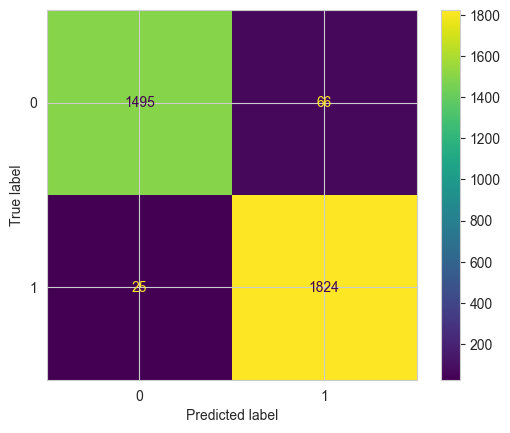

In [217]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='viridis')

# END